# Loan Performance Data Set - Classification of Loan Delinquency Status

In [1]:
import sys
import datetime as dt
import pandas as pd
import urllib.request
import zipfile, io
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn import metrics
from sklearn import neural_network
from sklearn.feature_selection import RFE
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

Preprocessing of Data

In [2]:
def preprocess(df_input):
    #Remove Spaces and Unknown
    df_input['CURRENT_LOAN_DELINQUENCY_STATUS'] = df_input['CURRENT_LOAN_DELINQUENCY_STATUS'].replace(['XX','   '],np.nan)
    df_input['REPURCHASE_FLAG'] = df_input['REPURCHASE_FLAG'].replace(['  '],'NA')
    df_input['MODIFICATION_FLAG'] = df_input['MODIFICATION_FLAG'].replace(['  '],'not_modfified')
    df_input['ZERO_BALANCE_CODE'] = df_input['ZERO_BALANCE_CODE'].replace(['  '],'NA')
    df_input['ZERO_BALANCE_EFFECTIVE_DATE'] = df_input['ZERO_BALANCE_EFFECTIVE_DATE'].replace(['      '],'NA')
    return df_input

In [3]:
def handleMissingData(df_input):
    #If null LOAN_SEQUENCE_NUMBER replace with NA
    df_input['LOAN_SEQUENCE_NUMBER'].fillna('NA',inplace=True)
    #If null replace CURRENT_ACTUAL_UPB with mean
    #df_input['CURRENT_ACTUAL_UPB'].fillna(0,inplace=True)
    #df_input['CURRENT_ACTUAL_UPB'].replace(0,df.Credit_Score.mean(),inplace=True)
    #If null Forward Fill or Bottom MONTHLY_REPORTING_PERIOD if null
    df_input.MONTHLY_REPORTING_PERIOD.fillna(method='ffill',inplace=True)
    df_input.MONTHLY_REPORTING_PERIOD.fillna(method='bfill',inplace=True)
    #Drop Rows of CURRENT_LOAN_DELINQUENCY_STATUS if Null
    df_input=df_input[~ df_input['CURRENT_LOAN_DELINQUENCY_STATUS'].isnull()]
    #Interpolate LOAN_AGE, REMAINING_MONTHS_TO_LEGAL_MATURITY
    df_input['LOAN_AGE'] = df_input['LOAN_AGE'].interpolate()
    df_input['REMAINING_MONTHS_TO_LEGAL_MATURITY'] = df_input['REMAINING_MONTHS_TO_LEGAL_MATURITY'].interpolate()
    #REPURCHASE_FLAG if null fill unknown
    df_input['REPURCHASE_FLAG'].fillna('unknown',inplace=True)
    #MODIFICATION_FLAG if null fill unknown
    df_input['MODIFICATION_FLAG'].fillna('unknown',inplace=True)
    #ZERO_BALANCE_CODE if null fill unknown
    df_input['ZERO_BALANCE_CODE'].fillna('unknown',inplace=True)
    #ZERO_BALANCE_EFFECTIVE_DATE if null fill NA    
    df_input['ZERO_BALANCE_EFFECTIVE_DATE'].fillna('NA',inplace=True)
    #CURRENT_INTEREST_RATE interpolate
    df_input['CURRENT_INTEREST_RATE'] = df_input['CURRENT_INTEREST_RATE'].interpolate()    
    #MI_RECOVERIES
    df_input['MI_RECOVERIES'].fillna(0,inplace=True)
    #NET_SALES_PROCEEDS 
    df_input['NET_SALES_PROCEEDS'].fillna(0,inplace=True)
    #NON_MI_RECOVERIES
    df_input['NON_MI_RECOVERIES'].fillna(0,inplace=True)
    #EXPENSES                      
    df_input['EXPENSES'].fillna(0,inplace=True)
    #Legal_Costs                   
    df_input['Legal_Costs'].fillna(0,inplace=True)
    #Maintenance_and_Preservation_Costs
    df_input['Maintenance_and_Preservation_Costs'].fillna(0,inplace=True)
    #Taxes_and_Insurance
    df_input['Taxes_and_Insurance'].fillna(0,inplace=True)
    #Miscellaneous_Expenses
    df_input['Miscellaneous_Expenses'].fillna(0,inplace=True)
    #Actual_Loss_Calculation
    df_input['Actual_Loss_Calculation'].fillna(0,inplace=True)
    #Modification_Cost
    df_input['Modification_Cost'].fillna(0,inplace=True)
    return df_input

In [4]:
def addNewColumnDelinquentorNonDelinquent(df):
    df['NEW_LOAN_DELINQUENCY_STATUS'] = pd.to_numeric(df.CURRENT_LOAN_DELINQUENCY_STATUS,errors = 'coerce')
    df['NEW_LOAN_DELINQUENCY_STATUS'].fillna(1, inplace = True)
    df_notZeros = df.NEW_LOAN_DELINQUENCY_STATUS[df['NEW_LOAN_DELINQUENCY_STATUS'] != 0]
    df_notZeros = df_notZeros/df_notZeros
    print(df_notZeros.shape)
    df_Zeros = df.NEW_LOAN_DELINQUENCY_STATUS[df['NEW_LOAN_DELINQUENCY_STATUS'] == 0]
    print(df_Zeros.shape)
    df_y = df_notZeros.append(df_Zeros)
    df['NEW_LOAN_DELINQUENCY_STATUS'] = df_y
    return df

In [5]:
def checkPercentageOfMissingData(df):
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    print(mis_val_percent)

In [6]:
def normalizeColumn(df_col):
    return preprocessing.normalize(df_col)

In [7]:
def createDFfromURL(fileURL):
    response = urllib.request.urlopen(fileURL)
    df = pd.DataFrame()
    if response.getcode()==200:
        data = response.read()
        if zipfile.is_zipfile(io.BytesIO(data)) == True:
            #print("Valid Zip file")
            z = zipfile.ZipFile(io.BytesIO(data))
            for file in z.namelist():
                #print(file)
                if file.find('_time_') != -1:
                    print("inside: "+file)
                    #print('Inside IF True')
                    csvFile = z.read(file)
                    df = pd.read_csv(io.BytesIO(csvFile),sep="|",header=None)
    print(df.shape)
    df.columns = ['LOAN_SEQUENCE_NUMBER','MONTHLY_REPORTING_PERIOD','CURRENT_ACTUAL_UPB','CURRENT_LOAN_DELINQUENCY_STATUS','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','REPURCHASE_FLAG','MODIFICATION_FLAG','ZERO_BALANCE_CODE','ZERO_BALANCE_EFFECTIVE_DATE','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','DUE_DATE_OF_LAST_PAID_INSTALLMENT','MI_RECOVERIES','NET_SALES_PROCEEDS','NON_MI_RECOVERIES','EXPENSES','Legal_Costs','Maintenance_and_Preservation_Costs','Taxes_and_Insurance','Miscellaneous_Expenses','Actual_Loss_Calculation','Modification_Cost','unknown']
    return df

In [8]:
def filterFrameWithRequiredFeatuers(df_input,df_input_test, ranking):
    df_new_train_x = pd.DataFrame()
    df_new_test_x = pd.DataFrame()
    print(df_new_test_x.head())
    for i in ranking_out:
        score,col_name  = i
        if score == 1:
            df_new_train_x[col_name] = df_input[col_name]
            df_new_test_x[col_name] = df_input_test[col_name]
    checkPercentageOfMissingData(df_new_train_x)
    checkPercentageOfMissingData(df_new_test_x)
    return (df_new_train_x,df_new_test_x)

In [9]:
def computeBestModel(list_of_model_and_accurancySocres):
    best_algo = None
    best_algo_accu_score = 0
    best_algo_model = None
    for value in list_of_model_and_accurancySocres:
        if best_algo != None:
            if value[1] > best_algo_accu_score:
                best_algo = value[0]
                best_algo_accu_score = value[1]
                best_algo_model = value[2] 
        else:
            best_algo = value[0]
            best_algo_accu_score = value[1]
            best_algo_model = value[2]
    print(best_algo + ' is best model with Accuracy Score of: ' +str(best_algo_accu_score))
    return best_algo

In [10]:
def logisticRegression(x_train, y_train):
    print('Logistic Regression model computation has started')
    model = LogisticRegression()
    model.fit(x_train,y_train)
    print('Logistic Regression model computation has completed')    
    return (model, 'Logistic Regression')
    #return model
def predictAndEvaluate(model,x_test,y_test):
    # predict class labels for the test set
    print('Model testing has started')
    predicted = model.predict(x_test)
    probs = model.predict_proba(x_test)[:, 1]
    print('Model testing has completed')
    # generate evaluation metrics
    accu_score = metrics.accuracy_score(y_test, predicted)
    print('Accuracy Score: ' + str(accu_score))
    cm = metrics.confusion_matrix(y_test, predicted)
    print('Confusion Matrix:')
    print(cm)
    y_test = y_test.astype(np.float)
    fpr, tpr, _ = metrics.roc_curve(y_test, probs)
    #Plot ROC curve
    %matplotlib inline
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    return (accu_score,cm)

In [11]:
def randomForestClassifier(x_train, y_train):
    print('Random Forest model computation has started')    
    model = RandomForestClassifier(n_jobs=2)
    model = model.fit(x_train,y_train)
    print('Random Forest model computation has completed')    
    return (model, 'Random Forest Classifier')

In [12]:
def neuralNetClassifier(x_train, y_train):
    print('Neural Network based Classification model computation has started')     
    model = neural_network.MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
    model = model.fit(x_train, y_train)
    print('Neural Network based Classification model computation has completed')     
    return (model,'Neural Network Classifier')

In [13]:
def svc(x_train, y_train):
    print('Support Vector Classification model computation has started')    
    model = svm.SVC(probability=True)
    model = model.fit(x_train, y_train) 
    print('Support Vector Classification model computation has completed')     
    return (model,'Support Vector Classification')

In [14]:
#Function to generate urlLIst for origination and next quarter URLs
def generateURLList(quarter,year):
    next_quarter = quarter +1
    next_year = year +1
    urlTrainList = []
    urlTestList = []
    train_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(year)+ ".zip"
    urlTrainList.append(train_url)
    if quarter == 4:
        quarter=1
        test_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(quarter)+str(next_year)+ ".zip"
        urlTestList.append(test_url)
    else:
        test_url = "https://freddiemac.embs.com/FLoan/Data/historical_data1_Q" + str(next_quarter)+str(year)+ ".zip"
        urlTestList.append(test_url) 
    return (urlTrainList,urlTestList)

In [15]:
urlTrainList,urlTestList = generateURLList(1,2006)
print(urlTrainList[0])
print(urlTestList[0])

https://freddiemac.embs.com/FLoan/Data/historical_data1_Q12006.zip
https://freddiemac.embs.com/FLoan/Data/historical_data1_Q22006.zip


In [16]:
df = createDFfromURL(urlTrainList[0])
df_test = createDFfromURL(urlTestList[0])

inside: historical_data1_time_Q12006.txt


/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


(19632673, 24)
inside: historical_data1_time_Q22006.txt
(18600067, 24)


In [17]:
#Preprocess Data, Handle Missing, Add NEW_LOAN_DELINQUENCY_STATUS 
df = preprocess(df)
df = handleMissingData(df)
df = addNewColumnDelinquentorNonDelinquent(df)

(1366952,)
(18265721,)


In [18]:
#Preprocess Data, Handle Missing, Add NEW_LOAN_DELINQUENCY_STATUS 
df_test = preprocess(df_test)
df_test = handleMissingData(df_test)
df_test = addNewColumnDelinquentorNonDelinquent(df_test)

/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/ipykernel/__main__.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/src/conda3_runtime/4.1.1/lib/python3.5/site-packages/pandas/core/generic.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

(1348198,)
(17251868,)


In [19]:
checkPercentageOfMissingData(df)
checkPercentageOfMissingData(df_test)

LOAN_SEQUENCE_NUMBER                   0.000000
MONTHLY_REPORTING_PERIOD               0.000000
CURRENT_ACTUAL_UPB                     0.000000
CURRENT_LOAN_DELINQUENCY_STATUS        0.000000
LOAN_AGE                               0.000000
REMAINING_MONTHS_TO_LEGAL_MATURITY     0.000000
REPURCHASE_FLAG                        0.000000
MODIFICATION_FLAG                      0.000000
ZERO_BALANCE_CODE                      0.000000
ZERO_BALANCE_EFFECTIVE_DATE            0.000000
CURRENT_INTEREST_RATE                  0.000000
CURRENT_DEFERRED_UPB                   0.000000
DUE_DATE_OF_LAST_PAID_INSTALLMENT     99.824655
MI_RECOVERIES                          0.000000
NET_SALES_PROCEEDS                     0.000000
NON_MI_RECOVERIES                      0.000000
EXPENSES                               0.000000
Legal_Costs                            0.000000
Maintenance_and_Preservation_Costs     0.000000
Taxes_and_Insurance                    0.000000
Miscellaneous_Expenses                 0

In [20]:
df.dtypes

LOAN_SEQUENCE_NUMBER                   object
MONTHLY_REPORTING_PERIOD                int64
CURRENT_ACTUAL_UPB                    float64
CURRENT_LOAN_DELINQUENCY_STATUS        object
LOAN_AGE                                int64
REMAINING_MONTHS_TO_LEGAL_MATURITY      int64
REPURCHASE_FLAG                        object
MODIFICATION_FLAG                      object
ZERO_BALANCE_CODE                      object
ZERO_BALANCE_EFFECTIVE_DATE            object
CURRENT_INTEREST_RATE                 float64
CURRENT_DEFERRED_UPB                  float64
DUE_DATE_OF_LAST_PAID_INSTALLMENT     float64
MI_RECOVERIES                         float64
NET_SALES_PROCEEDS                     object
NON_MI_RECOVERIES                     float64
EXPENSES                              float64
Legal_Costs                           float64
Maintenance_and_Preservation_Costs    float64
Taxes_and_Insurance                   float64
Miscellaneous_Expenses                float64
Actual_Loss_Calculation           

In [21]:
#Factorize Data
df['REPURCHASE_FLAG_FACTORIZE'] = pd.factorize(df['REPURCHASE_FLAG'])[0]
df['MODIFICATION_FLAG_FACTORIZE'] = pd.factorize(df['MODIFICATION_FLAG'])[0]
df['ZERO_BALANCE_CODE_FACTORIZE'] = pd.factorize(df['ZERO_BALANCE_CODE'])[0]
df_test['REPURCHASE_FLAG_FACTORIZE'] = pd.factorize(df_test['REPURCHASE_FLAG'])[0]
df_test['MODIFICATION_FLAG_FACTORIZE'] = pd.factorize(df_test['MODIFICATION_FLAG'])[0]
df_test['ZERO_BALANCE_CODE_FACTORIZE'] = pd.factorize(df_test['ZERO_BALANCE_CODE'])[0]

In [22]:
print(df.shape)
print(df_test.shape)

(19632673, 28)
(18600066, 28)


In [23]:
x_train = pd.DataFrame()
x_train = df[['CURRENT_ACTUAL_UPB','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','MI_RECOVERIES','NON_MI_RECOVERIES','Actual_Loss_Calculation','Modification_Cost','REPURCHASE_FLAG_FACTORIZE','MODIFICATION_FLAG_FACTORIZE','ZERO_BALANCE_CODE_FACTORIZE','EXPENSES']]
y_train = pd.DataFrame()
y_train['NEW_LOAN_DELINQUENCY_STATUS'] = df['NEW_LOAN_DELINQUENCY_STATUS']
y_train = np.ravel(y_train)
x_train.dtypes
x_test = pd.DataFrame()
x_test = df_test[['CURRENT_ACTUAL_UPB','LOAN_AGE','REMAINING_MONTHS_TO_LEGAL_MATURITY','CURRENT_INTEREST_RATE','CURRENT_DEFERRED_UPB','MI_RECOVERIES','NON_MI_RECOVERIES','Actual_Loss_Calculation','Modification_Cost','REPURCHASE_FLAG_FACTORIZE','MODIFICATION_FLAG_FACTORIZE','ZERO_BALANCE_CODE_FACTORIZE','EXPENSES']]
y_test = pd.DataFrame()
y_test['NEW_LOAN_DELINQUENCY_STATUS'] = df_test['NEW_LOAN_DELINQUENCY_STATUS']
y_test = np.ravel(y_test)
x_test.dtypes

CURRENT_ACTUAL_UPB                    float64
LOAN_AGE                                int64
REMAINING_MONTHS_TO_LEGAL_MATURITY      int64
CURRENT_INTEREST_RATE                 float64
CURRENT_DEFERRED_UPB                  float64
MI_RECOVERIES                         float64
NON_MI_RECOVERIES                     float64
Actual_Loss_Calculation               float64
Modification_Cost                     float64
REPURCHASE_FLAG_FACTORIZE               int64
MODIFICATION_FLAG_FACTORIZE             int64
ZERO_BALANCE_CODE_FACTORIZE             int64
EXPENSES                              float64
dtype: object

In [24]:
print(x_train.shape)
print(x_test.shape)

(19632673, 13)
(18600066, 13)


Logistic Regression model computation has started
Logistic Regression model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.928590683495
Confusion Matrix:
[[17248677     3191]
 [ 1325027    23171]]


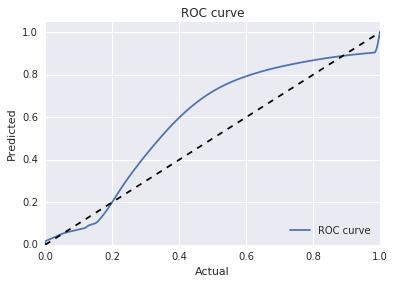

In [25]:
model, algo_name = logisticRegression(x_train, y_train)
accu_score,confusion_matrix = predictAndEvaluate(model, x_test, y_test)
#list_of_model_and_accurancySocres.append((algo_name,accu_score, model))

Random Forest model computation has started
Random Forest model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.897071386736
Confusion Matrix:
[[16454619   797249]
 [ 1117230   230968]]


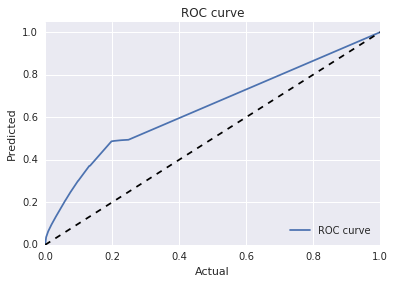

In [ ]:
model, algo_name = randomForestClassifier(x_train, y_train)
accu_score,confusion_matrix = predictAndEvaluate(model, x_test, y_test)
#list_of_model_and_accurancySocres.append((algo_name,accu_score, model))

In [ ]:
model, algo_name = neuralNetClassifier(x_train, y_train)
accu_score, confusion_matrix = predictAndEvaluate(model, x_test, y_test)
#list_of_model_and_accurancySocres.append((algo_name,accu_score, model))

Neural Network based Classification model computation has started
Neural Network based Classification model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.915058849791
Confusion Matrix:
[[16990339   261529]
 [ 1318382    29816]]


In [ ]:
#model,algo_name = svc(x_train.head(50000), y_train[0:50000])
#accu_score, confusion_matrix = predictAndEvaluate(model, x_test.head(50000), y_test[0:50000])
#list_of_model_and_accurancySocres.append((algo_name,accu_score, model))

In [ ]:
list_of_model_and_accurancySocres = []

In [ ]:
# Create the RFE object and rank each pixel
lr = LogisticRegression()
rfe = RFE(estimator=lr, n_features_to_select=5, step=2)
rfe.fit(x_train.head(1000000),y_train[0:1000000])
#ranking = rfe.ranking_.reshape(digits.images[0].shape)
ranking = rfe.ranking_
ranking_out = zip(map(lambda x: round(x, 4), rfe.ranking_), x_train.columns)
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_train.columns)))
df_train_x,df_test_x = filterFrameWithRequiredFeatuers(x_train,x_test, ranking_out)
print(df_train_x.shape)
print(df_test_x.shape)

[(1, 'CURRENT_INTEREST_RATE'), (1, 'LOAN_AGE'), (1, 'MODIFICATION_FLAG_FACTORIZE'), (1, 'REPURCHASE_FLAG_FACTORIZE'), (1, 'ZERO_BALANCE_CODE_FACTORIZE'), (2, 'EXPENSES'), (2, 'REMAINING_MONTHS_TO_LEGAL_MATURITY'), (3, 'MI_RECOVERIES'), (3, 'NON_MI_RECOVERIES'), (4, 'Actual_Loss_Calculation'), (4, 'CURRENT_DEFERRED_UPB'), (5, 'CURRENT_ACTUAL_UPB'), (5, 'Modification_Cost')]
Empty DataFrame
Columns: []
Index: []
LOAN_AGE                       0.0
CURRENT_INTEREST_RATE          0.0
REPURCHASE_FLAG_FACTORIZE      0.0
MODIFICATION_FLAG_FACTORIZE    0.0
ZERO_BALANCE_CODE_FACTORIZE    0.0
dtype: float64
LOAN_AGE                       0.0
CURRENT_INTEREST_RATE          0.0
REPURCHASE_FLAG_FACTORIZE      0.0
MODIFICATION_FLAG_FACTORIZE    0.0
ZERO_BALANCE_CODE_FACTORIZE    0.0
dtype: float64
(19632673, 5)
(18600066, 5)


In [ ]:
type(y_test)
counts,counts_1 = np.unique(y_test,return_counts=True)

In [ ]:
len(y_test)

18600066

In [ ]:
counts_1[0]

17251868

In [ ]:
col_names = ['Classification_Algorithm','Number_of_Actual_Delinquents','Number_of_predicted_delinquents','Number_of_records_in_dataset','Number_of_delinquents_properly_classified','Number_of_non- delinquents_improperly_classified_as_delinquents']
out_matrix = pd.DataFrame(columns=col_names)

In [ ]:
def addRowToDataFrame(confusion_matrix_input,y_values,col_names,output_matrix,algo_name_in):
    counts,counts_1 = np.unique(y_values,return_counts=True)
    temp = [counts_1[1],confusion_matrix_input[0][1]+confusion_matrix_input[1][1],len(y_values),confusion_matrix_input[1][1],confusion_matrix_input[0][1]]
    temp = np.asarray(temp)
    print(temp)
    print(temp[0])
    output_matrix = output_matrix.append({'Classification_Algorithm':algo_name_in,'Number_of_Actual_Delinquents':temp[0], 'Number_of_predicted_delinquents':temp[1],'Number_of_records_in_dataset':temp[2],'Number_of_delinquents_properly_classified':temp[3],'Number_of_non- delinquents_improperly_classified_as_delinquents':temp[4]}, ignore_index=True)
    return output_matrix

Logistic Regression model computation has started
Logistic Regression model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.929615733622
Confusion Matrix:
[[17250338     1530]
 [ 1307622    40576]]


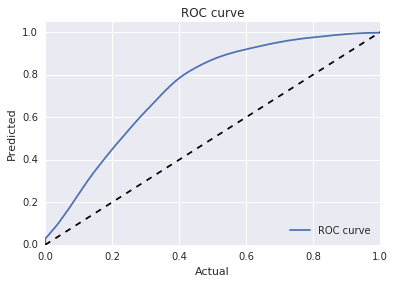

[ 1348198    42106 18600066    40576     1530]
1348198


In [ ]:
model,algo_name = logisticRegression(df_train_x,y_train)
accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,algo_name)

Random Forest model computation has started
Random Forest model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.929553314488
Confusion Matrix:
[[17245548     6320]
 [ 1303993    44205]]


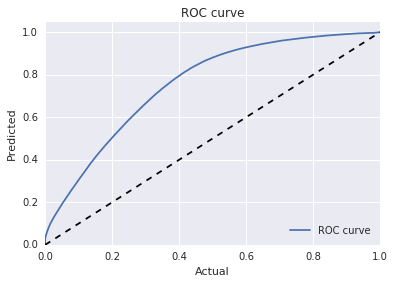

[ 1348198    50525 18600066    44205     6320]
1348198


In [ ]:
model, algo_name = randomForestClassifier(df_train_x, y_train)
accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,algo_name)

Neural Network based Classification model computation has started
Neural Network based Classification model computation has completed
Model testing has started
Model testing has completed
Accuracy Score: 0.928256867476
Confusion Matrix:
[[17251867        1]
 [ 1334426    13772]]


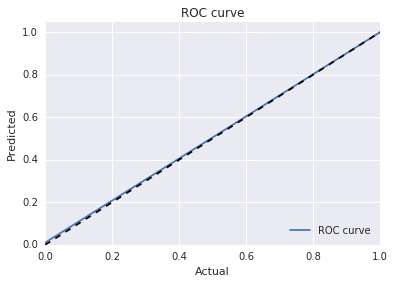

[ 1348198    13773 18600066    13772        1]
1348198


In [ ]:
model, algo_name = neuralNetClassifier(df_train_x, y_train)
accu_score, confusion_matrix = predictAndEvaluate(model, df_test_x, y_test)
list_of_model_and_accurancySocres.append((algo_name,accu_score, model))
out_matrix = addRowToDataFrame(confusion_matrix,y_test,col_names,out_matrix,algo_name)

In [ ]:
out_matrix

,Classification_Algorithm,Number_of_Actual_Delinquents,Number_of_predicted_delinquents,Number_of_records_in_dataset,Number_of_delinquents_properly_classified,Number_of_non- delinquents_improperly_classified_as_delinquents
0,Logistic Regression,1348198.0,42106.0,18600066.0,40576.0,1530.0
1,Random Forest Classifier,1348198.0,50525.0,18600066.0,44205.0,6320.0
2,Neural Network Classifier,1348198.0,13773.0,18600066.0,13772.0,1.0


In [ ]:
best_algo_picked = computeBestModel(list_of_model_and_accurancySocres)

Logistic Regression is best model with Accuracy Score of: 0.929615733622
